In [12]:
# %conda install scikit-image

In [13]:
import os
from pathlib import Path
import rasterio
import numpy as np
import os
import pandas as pd
import rasterio
from skimage import exposure
import matplotlib.pyplot as plt
import rasterio.plot as r_plot

np.seterr(divide='ignore', invalid='ignore')
os.chdir("/home/me/workspace/det_remota/trabalho_final")

AGGREGATED_RASTERS_PATH = Path("data/sentinel2/aggregated")
EQUALIZED_RASTERS_PATH = Path("data/sentinel2/equalized")
MATCHED_RASTERS_PATH = Path("data/sentinel2/matched")

In [ ]:
RGB_BANDS = [1,2,3]
INFRA_BANDS = [4,5,6]
INDEX_BANDS = [7,8,9,10]
MASK_BAND = 11


def contrast_stretching(raster_values): 
    p2, p98 = np.percentile(raster_values, (2, 98))
    return exposure.rescale_intensity(raster_values, in_range=(p2, p98))

def adapt_hist(raster_values): 
    return exposure.equalize_adapthist(raster_values)

def equalize_raster(raster, out_path: Path):
    rgb_raster = raster.read(RGB_BANDS)
    infra_raster = raster.read(INFRA_BANDS)
    index_raster = raster.read(INDEX_BANDS)
    
    rgb_eq = contrast_stretching(rgb_raster)
    infra_eq = contrast_stretching(infra_raster)
    index_eq = contrast_stretching(index_raster)
    # Adjusting the exposure had bad results for NDWI
    # index_eq = {
    #     band_idx: (
    #         index_rast if band_idx == 9
    #         else contrast_stretching(index_rast)
    #     ) 
    #     for band_idx, index_rast in index_rasters.items()
    # }
    # index_eq = index_rasters
    
    profile = raster.profile.copy()
    profile.update(count=10)
    with rasterio.open(out_path, 'w', **profile) as out_raster:
        out_raster.write(rgb_eq, indexes=RGB_BANDS)
        out_raster.write(infra_eq, indexes=INFRA_BANDS)
        out_raster.write(index_eq, indexes=INDEX_BANDS)
        # for band_idx, index_values in index_eq.items():
        #     out_raster.write(index_values, band_idx)
        out_raster.write_mask(raster.read(MASK_BAND))
    
    return rasterio.open(out_path)

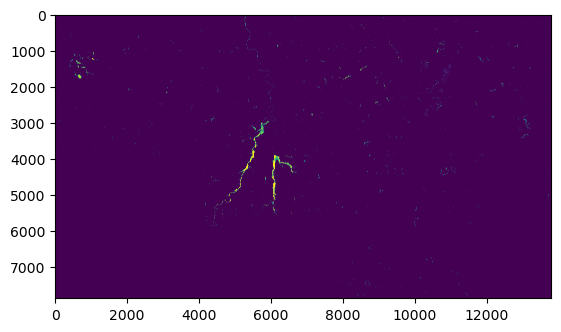

<Axes: >

In [15]:
raster_2017 = rasterio.open(AGGREGATED_RASTERS_PATH / "2017_08.tiff")
raster_2017_values_9 = raster_2017.read(9)
r_plot.show(raster_2017_values_9)


In [16]:
raster_2017 = rasterio.open(AGGREGATED_RASTERS_PATH / "2017_08.tiff")
out_path = Path(EQUALIZED_RASTERS_PATH / "2017_08.tiff")
equalized_2017 = equalize_raster(raster_2017, out_path)

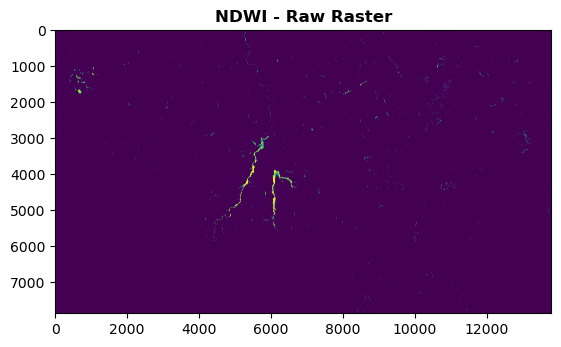

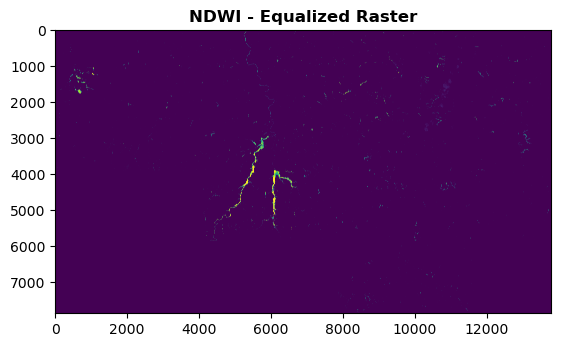

<Axes: title={'center': 'NDWI - Equalized Raster'}>

In [17]:
r_plot.show(raster_2017.read(9), title="NDWI - Raw Raster")
r_plot.show(equalized_2017.read(9), title="NDWI - Equalized Raster")

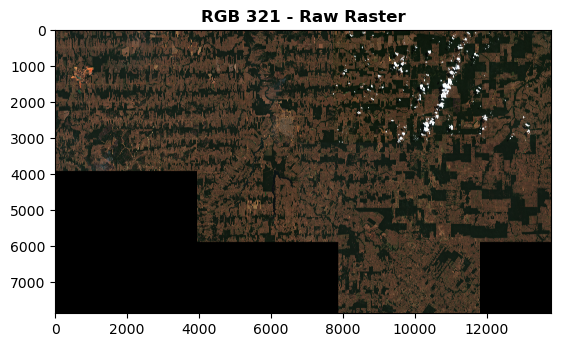

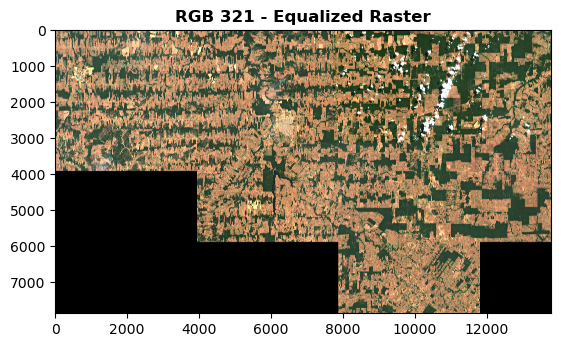

<Axes: title={'center': 'RGB 321 - Equalized Raster'}>

In [18]:
r_plot.show(raster_2017.read([1,2,3]), title="RGB 321 - Raw Raster")
r_plot.show(equalized_2017.read([1,2,3]), title="RGB 321 - Equalized Raster")

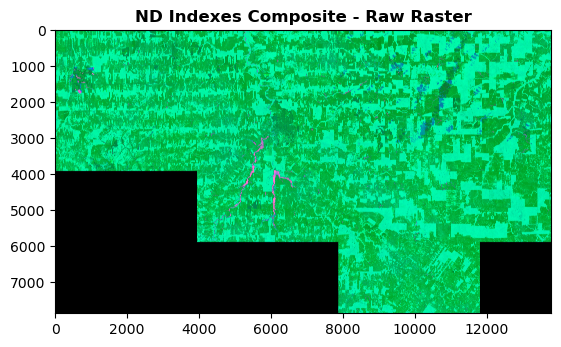

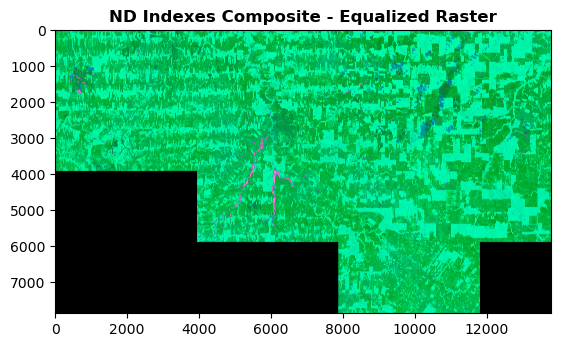

<Axes: title={'center': 'ND Indexes Composite - Equalized Raster'}>

In [19]:
r_plot.show(raster_2017.read([9,8,7]), title="ND Indexes Composite - Raw Raster")
r_plot.show(equalized_2017.read([9,8,7]), title="ND Indexes Composite - Equalized Raster")

In [20]:
import shutil

shutil.copy(
    raster_2017.files[0],
    MATCHED_RASTERS_PATH / "2017_08.tiff"
)

PosixPath('data/sentinel2/matched/2017_08.tiff')

In [21]:
for raw_raster_path in AGGREGATED_RASTERS_PATH.glob('*.tiff'):
    filename = str(raw_raster_path).split('/')[-1]
    if filename == '2017_08.tiff':
        continue
    equalized_out_path = EQUALIZED_RASTERS_PATH / filename
    matched_out_path = MATCHED_RASTERS_PATH / filename

    with rasterio.open(raw_raster_path) as raw_raster:
        equalized_raster = equalize_raster(raw_raster, equalized_out_path)
        matched_raster = exposure.match_histograms(equalized_raster.read(), equalized_2017.read())
        profile = equalized_raster.profile.copy()

    with rasterio.open(matched_out_path, 'w', **profile) as out_raster:
        out_raster.write(matched_raster)

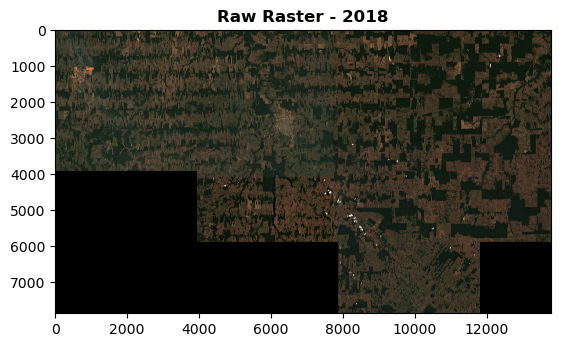

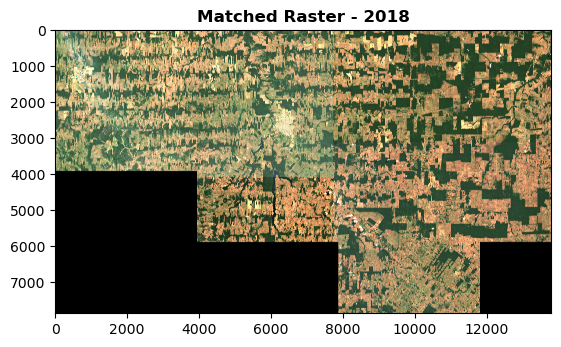

<Axes: title={'center': 'Matched Raster - 2018'}>

In [22]:
raster_2018 = rasterio.open(AGGREGATED_RASTERS_PATH / '2018_08.tiff')
raster_2018_matched = rasterio.open(MATCHED_RASTERS_PATH / '2018_08.tiff')

r_plot.show(raster_2018.read([1,2,3]), title="Raw Raster - 2018")
r_plot.show(raster_2018_matched.read([1,2,3]), title="Matched Raster - 2018")